# Laboratorium 1

## Autor: Tomasz Boroń

### Konfiguracja

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

In [75]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 3), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

In [74]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


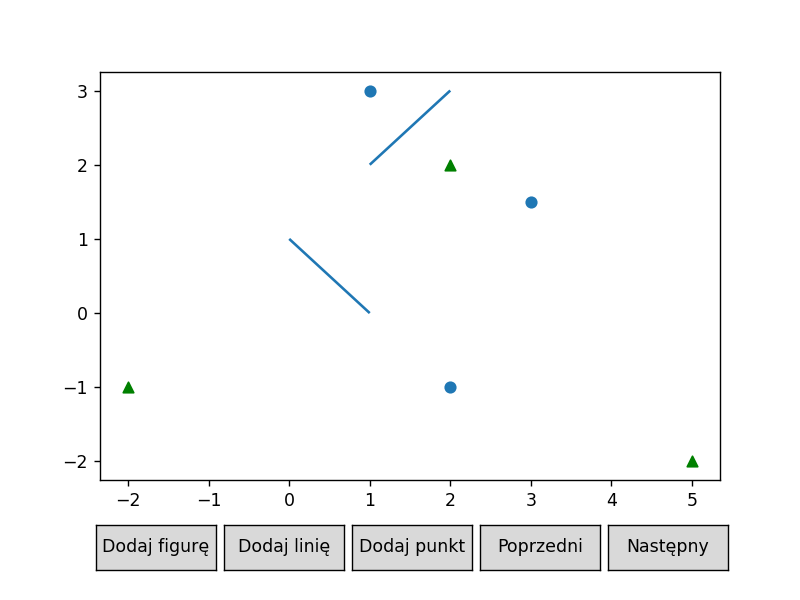

In [7]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


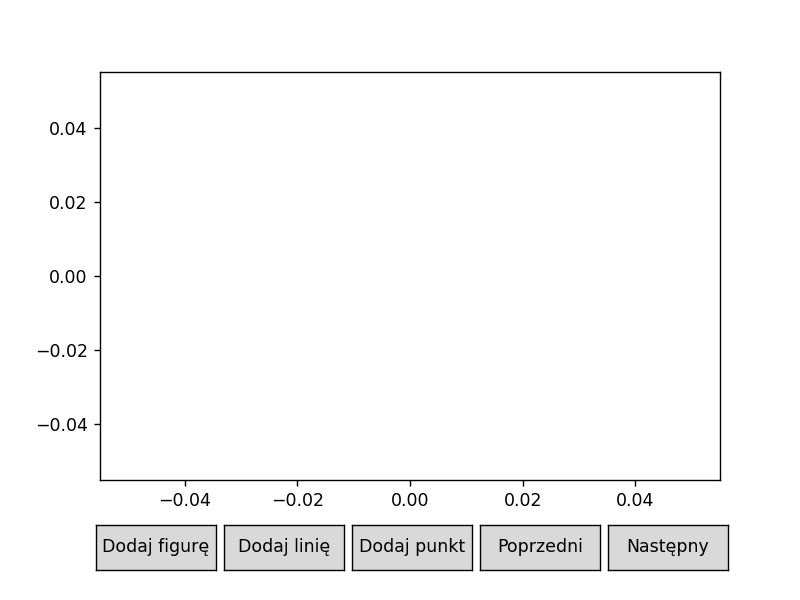

In [8]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


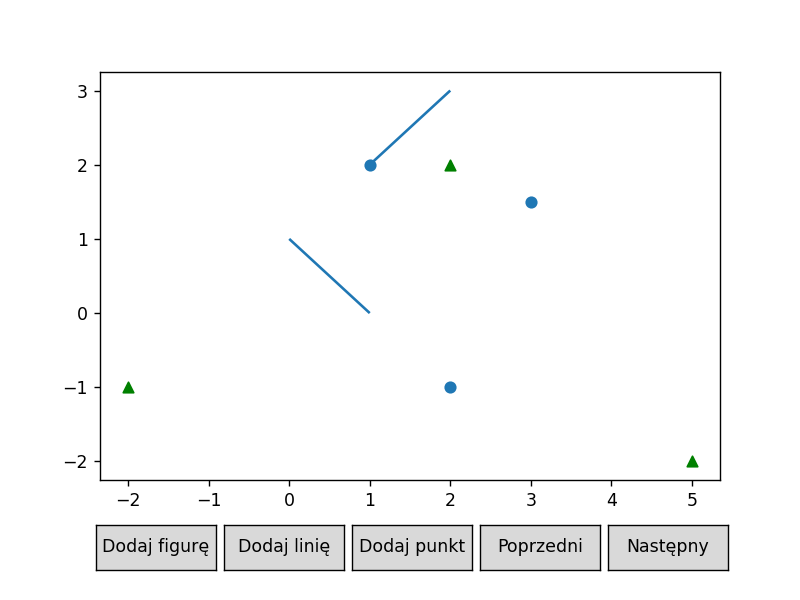

In [112]:
%matplotlib notebook
scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 

# FirstGen

In [4]:
from random import random

p1=[]
for i in range(100000):
    p1.append( (random()*2000-1000 , random()*2000-1000) )

# SecondGen

In [5]:
p2=[]
for i in range(100000):
    p2.append( (random()*2*(10**14)-10**14 , random()*2*(10**14)-10**14) )

# ThirdGen

In [6]:
from math import sin,cos,pi

p3=[]
R=100
for i in range(1000):
    angle=random()*2*pi
    p3.append( (R*cos(angle), R*sin(angle)) )

# FourthGen

In [7]:
p4=[]
for i in range(1000):
    t=1+random()*1000-500
    p4.append( (-1.0+t*2.0,t*0.1) )

# ShowFirst

<IPython.core.display.Javascript object>


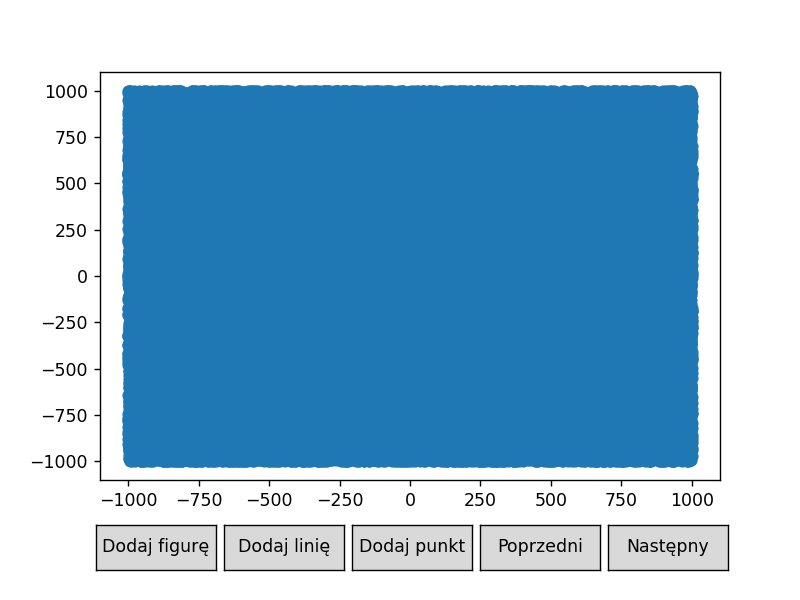

In [8]:
%matplotlib notebook

plot1 = Plot(points=[PointsCollection(p1)])
plot1.draw()

# Show Second

<IPython.core.display.Javascript object>


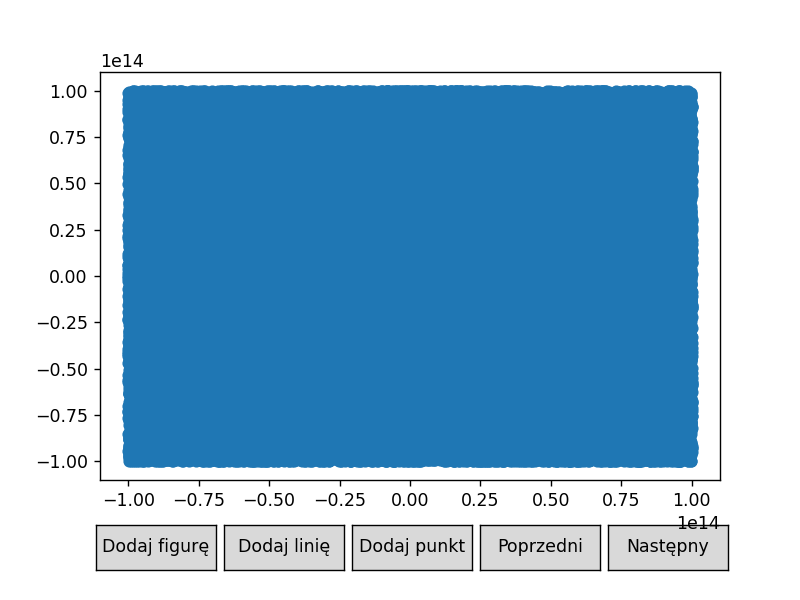

In [9]:
%matplotlib notebook

plot2 = Plot(points=[PointsCollection(p2)])
plot2.draw()

# ShowThird

<IPython.core.display.Javascript object>


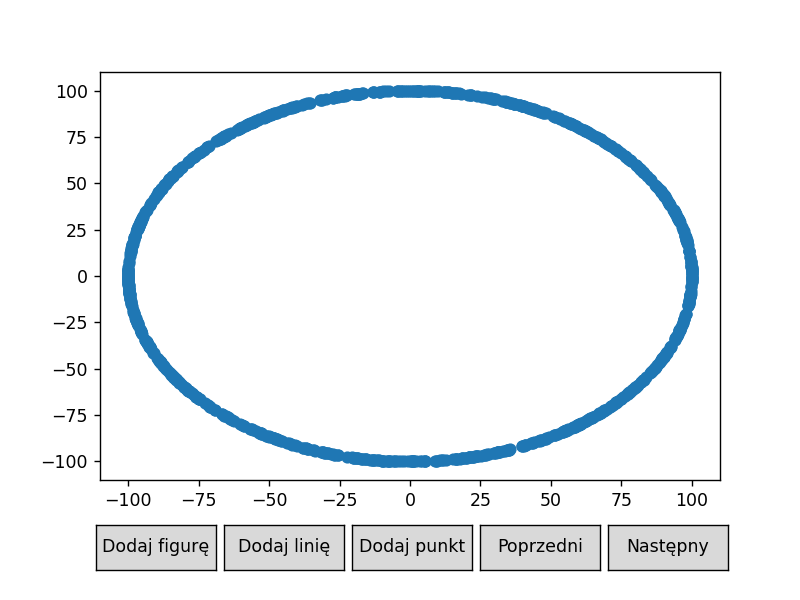

In [10]:
%matplotlib notebook

plot3 = Plot(points=[PointsCollection(p3)])
plot3.draw()

# ShowFourth

<IPython.core.display.Javascript object>


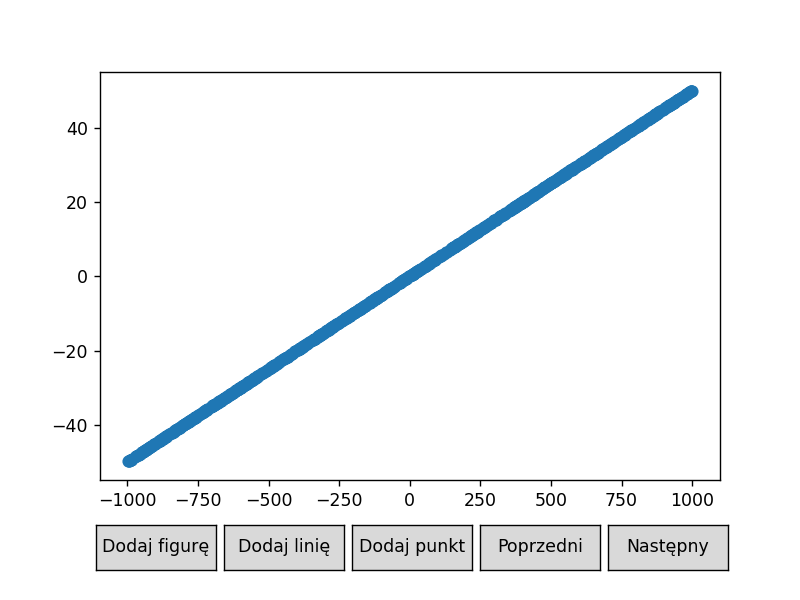

In [11]:
%matplotlib notebook

plot4 = Plot(points=[PointsCollection(p4)])
plot4.draw()

# Det 3x3

In [12]:
def det3(a,b,c):
    return a[0]*b[1]+c[0]*a[1]+b[0]*c[1]-c[0]*b[1]-a[0]*c[1]-b[0]*a[1]

# Det 2x2

In [13]:
def det2(a,b,c):
    return (a[0]-c[0])*(b[1]-c[1])-(b[0]-c[0])*(a[1]-c[1])

# Init

In [14]:
a=(-1.0,0.0)
b=(1.0,0.1)
left=[]
right=[]
straight=[]
zero=10**-14

# Dividing points by det3x3

In [15]:
def divide_by_3x3det(a,b,points_set):
    left.clear()
    straight.clear()
    right.clear()
    for i in range(len(points_set)):
        point=points_set[i]
        if det3(a,b,point)>zero: left.append((point[0],point[1],1))   # ostatni element tupla to status jaki ma punkt 1 - left, 2 - colinear, 3 - right
        elif det3(a,b,point)<=zero and det3(a,b,point)>=-1*zero: straight.append((point[0],point[1],2))
        else: right.append((point[0],point[1],3))

# Dividing points by det 2x2

In [16]:
def divide_by_2x2det(a,b,points_set):
    left.clear()
    straight.clear()
    right.clear()
    for i in range(len(points_set)):
        point=points_set[i]
        if det2(a,b,point)>zero: left.append((point[0],point[1],1))
        elif det2(a,b,point)<=zero and det2(a,b,point)>=-1*zero: straight.append((point[0],point[1],2))
        else: right.append((point[0],point[1],3))

# Dividing points by Numpy det 3x3

In [17]:
import numpy as np

def divide_by_py_det(a,b,points_set):
    left.clear()
    straight.clear()
    right.clear()
    for i in range(len(points_set)):
        point=points_set[i]
        mac=[
            [a[0],a[1],1],
            [b[0],b[1],1],
            [point[0],point[1],1]
        ]
        d=np.linalg.det(mac)
        if d>zero: left.append((point[0],point[1],1))
        elif d<=zero and d>=-1*zero: straight.append((point[0],point[1],2))
        else: right.append((point[0],point[1],3))

# Dividing points by Numpy det 2x2

In [18]:
def divide_by_py_det2x2(a,b,points_set):
    left.clear()
    straight.clear()
    right.clear()
    for i in range(len(points_set)):
        point=points_set[i]
        mac=[
            [a[0]-point[0],a[1]-point[1]],
            [b[0]-point[0],b[1]-point[1]]
        ]
        d=np.linalg.det(mac)
        if d>zero: left.append((point[0],point[1],1))
        elif d<=zero and d>=-1*zero: straight.append((point[0],point[1],2))
        else: right.append((point[0],point[1],3))

# Visualisation for 3x3, p1 set

<IPython.core.display.Javascript object>


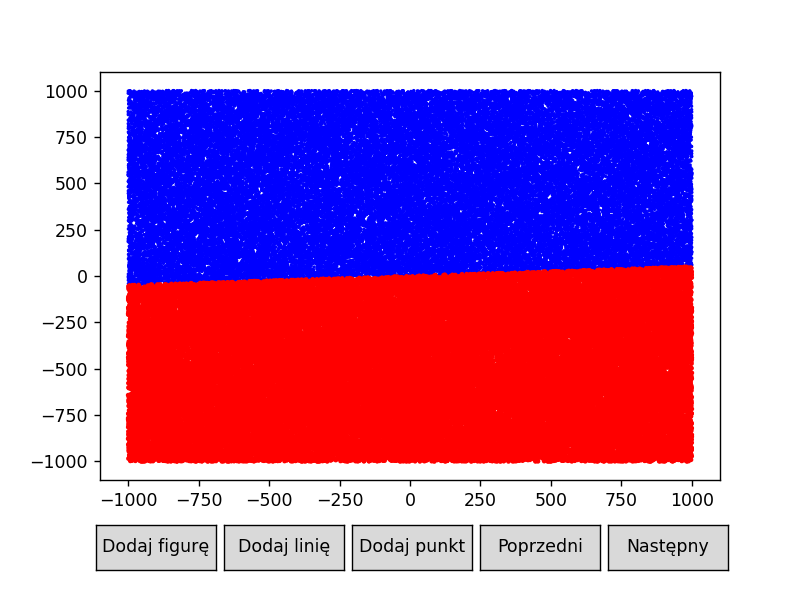

In [19]:
%matplotlib notebook

points_set=p1 
divide_by_3x3det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(straight,color='green'),
            PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red')
            ]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 2x2, p1 set

<IPython.core.display.Javascript object>


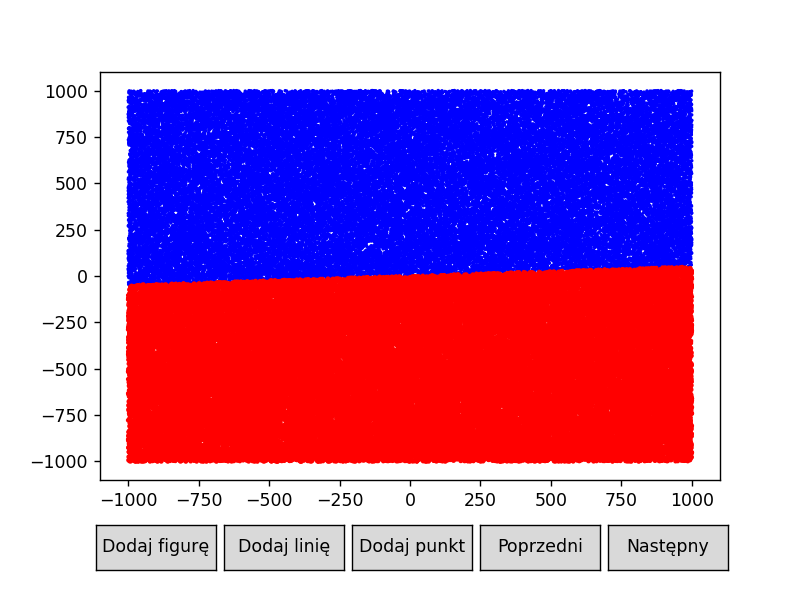

In [176]:
%matplotlib notebook

points_set=p1
divide_by_2x2det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red'), 
            PointsCollection(straight,color='green')]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 3x3, p2 set

<IPython.core.display.Javascript object>


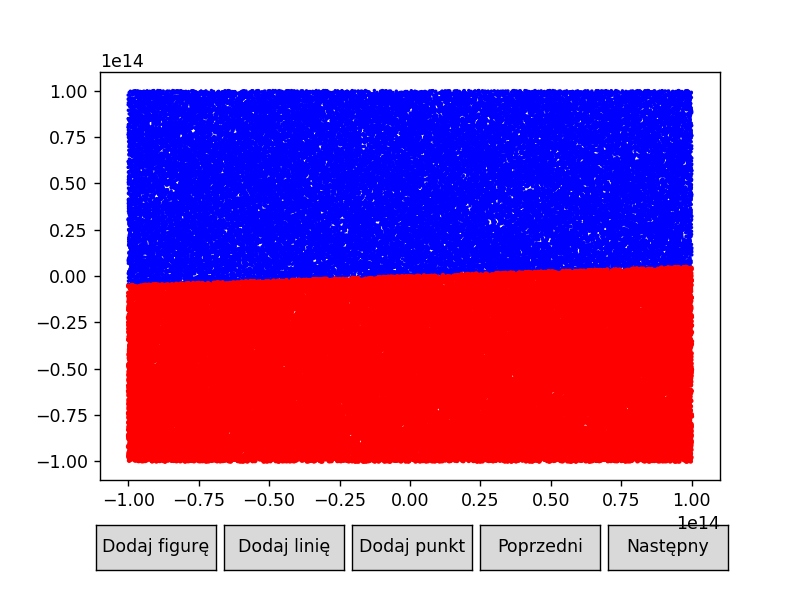

In [177]:
%matplotlib notebook

points_set=p2 
divide_by_3x3det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(straight,color='green'),
            PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red')
            ]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 2x2, p2 set

<IPython.core.display.Javascript object>


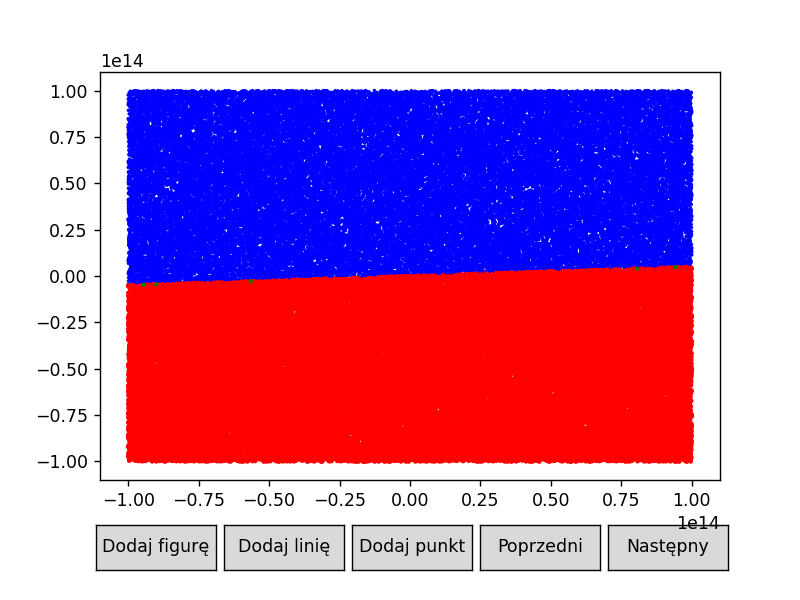

In [178]:
%matplotlib notebook

points_set=p2
divide_by_2x2det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red'), 
            PointsCollection(straight,color='green')]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 3x3, p3 set

<IPython.core.display.Javascript object>


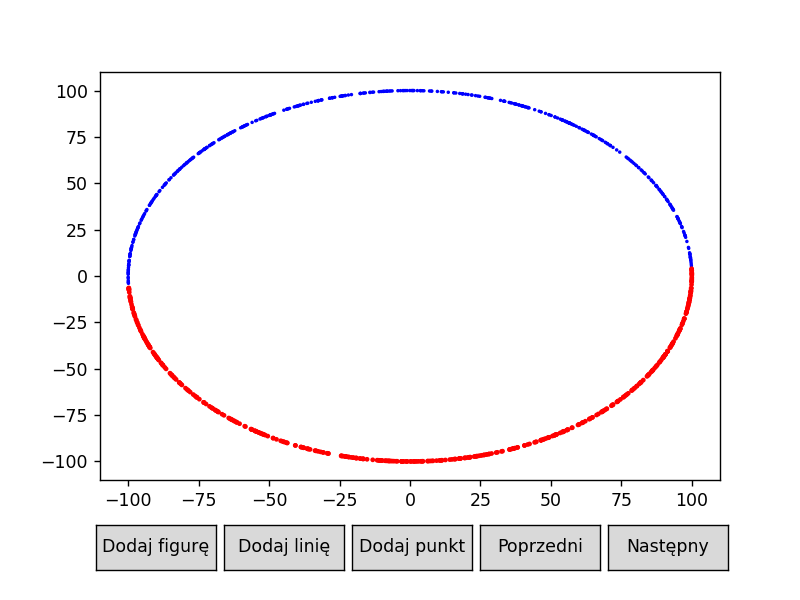

In [179]:
%matplotlib notebook

points_set=p3 
divide_by_3x3det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(straight,color='green'),
            PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red')
            ]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 2x2, p3 set

<IPython.core.display.Javascript object>


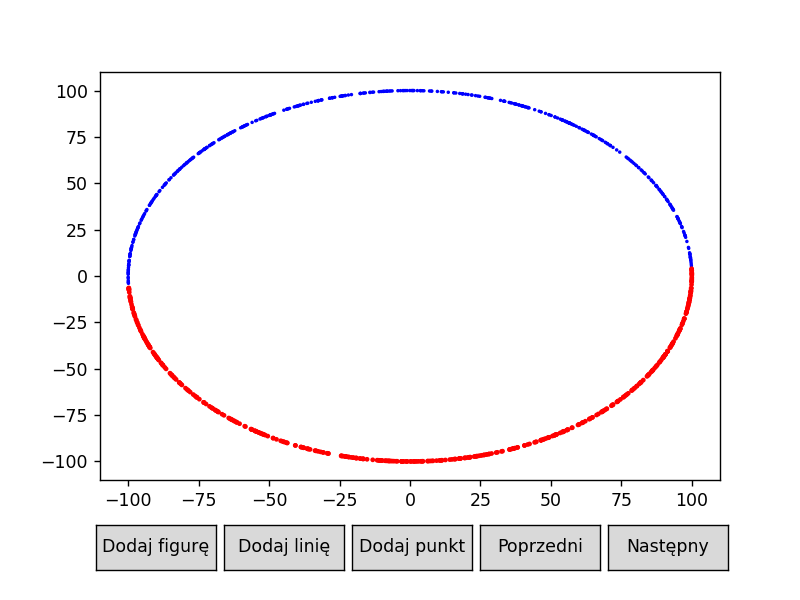

In [180]:
%matplotlib notebook

points_set=p3
divide_by_2x2det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red'), 
            PointsCollection(straight,color='green')]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 3x3, p4 set

<IPython.core.display.Javascript object>


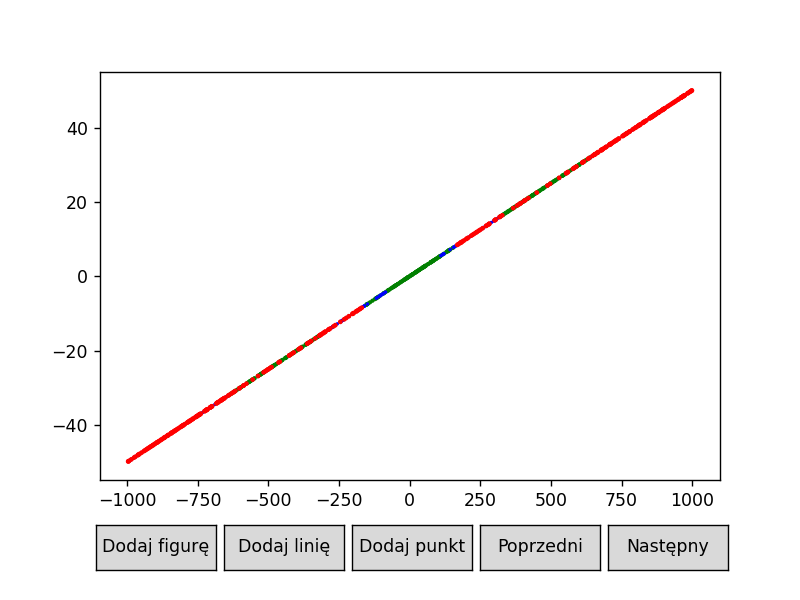

In [181]:
%matplotlib notebook

points_set=p4 
divide_by_3x3det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(straight,color='green'),
            PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red')
            ]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

# Visualisation for 2x2, p4 set

<IPython.core.display.Javascript object>


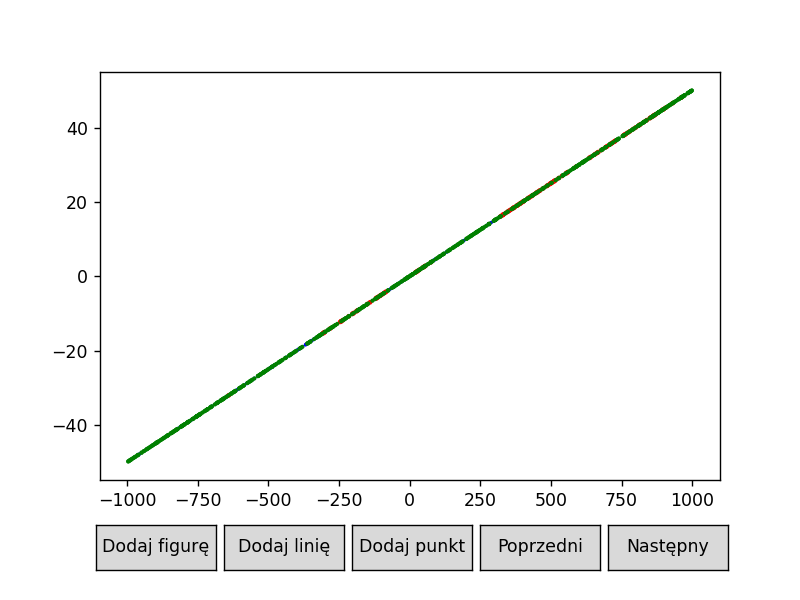

In [182]:
%matplotlib notebook

points_set=p4
divide_by_2x2det(a,b,points_set)
scenes=[Scene (
                [PointsCollection(points_set,color="darkblue")] 
              ), 
            Scene (
            [PointsCollection(left,color='blue'), 
            PointsCollection(right,color='red'), 
            PointsCollection(straight,color='green')]
              )
           ]
plot=Plot(scenes = scenes)
plot.draw() 

## Compare all

In [22]:
def comp(points_set):
    divide_by_3x3det(a,b,points_set)
    print("Wyznacznik 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_2x2det(a,b,points_set)
    print("Wyznacznik 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det(a,b,points_set)
    print("Wyznacznik 3x3 Numpy: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det2x2(a,b,points_set)
    print("Wyznacznik 2x2 Numpy: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
comp(p1)
print()
print("Zbior 2: ")
comp(p2)
print()
print("Zbior 3: ")
comp(p3)
print()
print("Zbior 4: ")
comp(p4)
print()

Zbior 1: 
Wyznacznik 3x3: 
Na lewo:  50128
Na prawo:  49872
Wspoliniowo:  0
Wyznacznik 2x2: 
Na lewo:  50128
Na prawo:  49872
Wspoliniowo:  0
Wyznacznik 3x3 Numpy: 
Na lewo:  50128
Na prawo:  49872
Wspoliniowo:  0
Wyznacznik 2x2 Numpy: 
Na lewo:  50128
Na prawo:  49872
Wspoliniowo:  0

Zbior 2: 
Wyznacznik 3x3: 
Na lewo:  49765
Na prawo:  50235
Wspoliniowo:  0
Wyznacznik 2x2: 
Na lewo:  49761
Na prawo:  50232
Wspoliniowo:  7
Wyznacznik 3x3 Numpy: 
Na lewo:  49765
Na prawo:  50235
Wspoliniowo:  0
Wyznacznik 2x2 Numpy: 
Na lewo:  49764
Na prawo:  50236
Wspoliniowo:  0

Zbior 3: 
Wyznacznik 3x3: 
Na lewo:  482
Na prawo:  518
Wspoliniowo:  0
Wyznacznik 2x2: 
Na lewo:  482
Na prawo:  518
Wspoliniowo:  0
Wyznacznik 3x3 Numpy: 
Na lewo:  482
Na prawo:  518
Wspoliniowo:  0
Wyznacznik 2x2 Numpy: 
Na lewo:  482
Na prawo:  518
Wspoliniowo:  0

Zbior 4: 
Wyznacznik 3x3: 
Na lewo:  0
Na prawo:  0
Wspoliniowo:  1000
Wyznacznik 2x2: 
Na lewo:  120
Na prawo:  164
Wspoliniowo:  716
Wyznacznik 3x3 Numpy

# Compare my 3x3 vs my 2x2

In [19]:
def count(points_set):
    divide_by_3x3det(a,b,points_set)
    print("Wyznacznik 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_2x2det(a,b,points_set)
    print("Wyznacznik 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
count(p1)
print()
print("Zbior 2: ")
count(p2)
print()
print("Zbior 3: ")
count(p3)
print()
print("Zbior 4: ")
count(p4)
print()

Zbior 1: 
Wyznacznik 3x3: 
Na lewo:  49925
Na prawo:  50075
Wspoliniowo:  0
Wyznacznik 2x2: 
Na lewo:  49925
Na prawo:  50075
Wspoliniowo:  0

Zbior 2: 
Wyznacznik 3x3: 
Na lewo:  49725
Na prawo:  50275
Wspoliniowo:  0
Wyznacznik 2x2: 
Na lewo:  49723
Na prawo:  50272
Wspoliniowo:  5

Zbior 3: 
Wyznacznik 3x3: 
Na lewo:  492
Na prawo:  508
Wspoliniowo:  0
Wyznacznik 2x2: 
Na lewo:  492
Na prawo:  508
Wspoliniowo:  0

Zbior 4: 
Wyznacznik 3x3: 
Na lewo:  0
Na prawo:  0
Wspoliniowo:  1000
Wyznacznik 2x2: 
Na lewo:  130
Na prawo:  148
Wspoliniowo:  722



# Differences my 3x3 vs my 2x2

In [184]:
divide_by_3x3det(a,b,p2)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_2x2det(a,b,p2)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]:
        str1=""
        str2=""
        if set1[i][2]==1:
            str1=" na lewo "
        elif set1[i][2]==2:
            str1=" wprost "
        else:
            str1=" na prawo "
        if set2[i][2]==1:
            str2=" na lewo "
        elif set2[i][2]==2:
            str2=" wprost "
        else:
            str2=" na prawo "
        print("Roznica dla punktu ",(set1[i][0],set1[i][1])," w pierwszym przypadku jest",str1,"a w drugim",str2)
        diff.append((set1[i][0],set1[i][1]))
print("Ilosc roznic: ",len(diff))

Roznica dla punktu  (-94518986707337.5, -4685010744268.531)  w pierwszym przypadku jest  na lewo  a w drugim  wprost 
Roznica dla punktu  (-90043580139496.05, -4489982605721.75)  w pierwszym przypadku jest  na lewo  a w drugim  wprost 
Roznica dla punktu  (-56527414354889.93, -2837216332028.625)  w pierwszym przypadku jest  na prawo  a w drugim  wprost 
Roznica dla punktu  (80466038003869.62, 4002774530306.8906)  w pierwszym przypadku jest  na prawo  a w drugim  wprost 
Roznica dla punktu  (94181960922188.88, 4702407878860.453)  w pierwszym przypadku jest  na prawo  a w drugim  wprost 
Ilosc roznic:  5


# Compare 3x3 with Numpy 3x3

In [185]:
def count2(points_set):
    divide_by_3x3det(a,b,points_set)
    print("Wyznacznik 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det(a,b,points_set)
    print("Wyznacznik numpy 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
count2(p1)
print()
print("Zbior 2: ")
count2(p2)
print()
print("Zbior 3: ")
count2(p3)
print()
print("Zbior 4: ")
count2(p4)
print()

Zbior 1: 
Wyznacznik 3x3: 
Na lewo:  50029
Na prawo:  49971
Wspoliniowo:  0
Wyznacznik numpy 3x3: 
Na lewo:  50029
Na prawo:  49971
Wspoliniowo:  0

Zbior 2: 
Wyznacznik 3x3: 
Na lewo:  49865
Na prawo:  50135
Wspoliniowo:  0
Wyznacznik numpy 3x3: 
Na lewo:  49865
Na prawo:  50135
Wspoliniowo:  0

Zbior 3: 
Wyznacznik 3x3: 
Na lewo:  490
Na prawo:  510
Wspoliniowo:  0
Wyznacznik numpy 3x3: 
Na lewo:  490
Na prawo:  510
Wspoliniowo:  0

Zbior 4: 
Wyznacznik 3x3: 
Na lewo:  258
Na prawo:  357
Wspoliniowo:  385
Wyznacznik numpy 3x3: 
Na lewo:  353
Na prawo:  347
Wspoliniowo:  300



# Differences 3x3 with Numpy 3x3

In [186]:
divide_by_3x3det(a,b,p3)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det(a,b,p3)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]:
        str1=""
        str2=""
        if set1[i][2]==1:
            str1=" na lewo "
        elif set1[i][2]==2:
            str1=" wprost "
        else:
            str1=" na prawo "
        if set2[i][2]==1:
            str2=" na lewo "
        elif set2[i][2]==2:
            str2=" wprost "
        else:
            str2=" na prawo "
        print("Roznica dla punktu ",(set1[i][0],set1[i][1])," w pierwszym przypadku jest",str1,"a w drugim",str2)
        diff.append((set1[i][0],set1[i][1]))
print("Ilosc roznic: ",len(diff))

Ilosc roznic:  0


# Compare 3x3 with Numpy 2x2

In [187]:
def count3(points_set):
    divide_by_3x3det(a,b,points_set)
    print("Wyznacznik 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det2x2(a,b,points_set)
    print("Wyznacznik numpy 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
count3(p1)
print()
print("Zbior 2: ")
count3(p2)
print()
print("Zbior 3: ")
count3(p3)
print()
print("Zbior 4: ")
count3(p4)
print()

Zbior 1: 
Wyznacznik 3x3: 
Na lewo:  50029
Na prawo:  49971
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  50029
Na prawo:  49971
Wspoliniowo:  0

Zbior 2: 
Wyznacznik 3x3: 
Na lewo:  49865
Na prawo:  50135
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  49865
Na prawo:  50135
Wspoliniowo:  0

Zbior 3: 
Wyznacznik 3x3: 
Na lewo:  490
Na prawo:  510
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  490
Na prawo:  510
Wspoliniowo:  0

Zbior 4: 
Wyznacznik 3x3: 
Na lewo:  258
Na prawo:  357
Wspoliniowo:  385
Wyznacznik numpy 2x2: 
Na lewo:  497
Na prawo:  459
Wspoliniowo:  44



# Differences 3x3 with Numpy 2x2

In [188]:
divide_by_3x3det(a,b,p2)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det2x2(a,b,p2)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]:
        str1=""
        str2=""
        if set1[i][2]==1:
            str1=" na lewo "
        elif set1[i][2]==2:
            str1=" wprost "
        else:
            str1=" na prawo "
        if set2[i][2]==1:
            str2=" na lewo "
        elif set2[i][2]==2:
            str2=" wprost "
        else:
            str2=" na prawo "
        print("Roznica dla punktu ",(set1[i][0],set1[i][1])," w pierwszym przypadku jest",str1,"a w drugim",str2)
        diff.append((set1[i][0],set1[i][1]))
print("Ilosc roznic: ",len(diff))

Roznica dla punktu  (-90043580139496.05, -4489982605721.75)  w pierwszym przypadku jest  na lewo  a w drugim  na prawo 
Roznica dla punktu  (94181960922188.88, 4702407878860.453)  w pierwszym przypadku jest  na prawo  a w drugim  na lewo 
Ilosc roznic:  2


# Compare 2x2 with Numpy 3x3

In [131]:
def count4(points_set):
    divide_by_2x2det(a,b,points_set)
    print("Wyznacznik 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det(a,b,points_set)
    print("Wyznacznik numpy 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
count4(p1)
print()
print("Zbior 2: ")
count4(p2)
print()
print("Zbior 3: ")
count4(p3)
print()
print("Zbior 4: ")
count4(p4)
print()

Zbior 1: 
Wyznacznik 2x2: 
Na lewo:  49951
Na prawo:  50049
Wspoliniowo:  0
Wyznacznik numpy 3x3: 
Na lewo:  49951
Na prawo:  50049
Wspoliniowo:  0

Zbior 2: 
Wyznacznik 2x2: 
Na lewo:  49875
Na prawo:  50120
Wspoliniowo:  5
Wyznacznik numpy 3x3: 
Na lewo:  49877
Na prawo:  50123
Wspoliniowo:  0

Zbior 3: 
Wyznacznik 2x2: 
Na lewo:  494
Na prawo:  506
Wspoliniowo:  0
Wyznacznik numpy 3x3: 
Na lewo:  494
Na prawo:  506
Wspoliniowo:  0

Zbior 4: 
Wyznacznik 2x2: 
Na lewo:  271
Na prawo:  326
Wspoliniowo:  403
Wyznacznik numpy 3x3: 
Na lewo:  86
Na prawo:  43
Wspoliniowo:  871



# Differences 2x2 with Numpy 3x3

In [87]:
divide_by_2x2det(a,b,p2)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det(a,b,p2)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]:
        str1=""
        str2=""
        if set1[i][2]==1:
            str1=" na lewo "
        elif set1[i][2]==2:
            str1=" wprost "
        else:
            str1=" na prawo "
        if set2[i][2]==1:
            str2=" na lewo "
        elif set2[i][2]==2:
            str2=" wprost "
        else:
            str2=" na prawo "
        print("Roznica dla punktu ",(set1[i][0],set1[i][1])," w pierwszym przypadku jest",str1,"a w drugim",str2)
        diff.append((set1[i][0],set1[i][1]))
print("Ilosc roznic: ",len(diff))

Roznica dla punktu  (-87543530729737.95, -4366823195541.7812)  w pierwszym przypadku jest  wprost  a w drugim  na lewo 
Roznica dla punktu  (-62383839553236.5, -3111804874590.2188)  w pierwszym przypadku jest  wprost  a w drugim  na lewo 
Roznica dla punktu  (24074183589033.266, 1203176299399.6094)  w pierwszym przypadku jest  wprost  a w drugim  na prawo 
Roznica dla punktu  (62577032778150.91, 3119958289399.0312)  w pierwszym przypadku jest  wprost  a w drugim  na prawo 
Roznica dla punktu  (79467232789389.22, 3980662418475.4844)  w pierwszym przypadku jest  wprost  a w drugim  na lewo 
Roznica dla punktu  (97079745577934.5, 4841756450863.531)  w pierwszym przypadku jest  na lewo  a w drugim  na prawo 
Ilosc roznic:  6


# Compare 2x2 with Numpy 2x2

In [41]:
def count5(points_set):
    divide_by_2x2det(a,b,points_set)
    print("Wyznacznik 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det2x2(a,b,points_set)
    print("Wyznacznik numpy 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
count5(p1)
print()
print("Zbior 2: ")
count5(p2)
print()
print("Zbior 3: ")
count5(p3)
print()
print("Zbior 4: ")
count5(p4)
print()

Zbior 1: 
Wyznacznik 2x2: 
Na lewo:  50073
Na prawo:  49927
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  50073
Na prawo:  49927
Wspoliniowo:  0

Zbior 2: 
Wyznacznik 2x2: 
Na lewo:  49889
Na prawo:  50105
Wspoliniowo:  6
Wyznacznik numpy 2x2: 
Na lewo:  49892
Na prawo:  50108
Wspoliniowo:  0

Zbior 3: 
Wyznacznik 2x2: 
Na lewo:  502
Na prawo:  498
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  502
Na prawo:  498
Wspoliniowo:  0

Zbior 4: 
Wyznacznik 2x2: 
Na lewo:  144
Na prawo:  146
Wspoliniowo:  710
Wyznacznik numpy 2x2: 
Na lewo:  516
Na prawo:  484
Wspoliniowo:  0



# Differences 2x2 with Numpy 2x2

In [21]:
divide_by_2x2det(a,b,p4)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det2x2(a,b,p4)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]:
        str1=""
        str2=""
        if set1[i][2]==1:
            str1=" na lewo "
        elif set1[i][2]==2:
            str1=" wprost "
        else:
            str1=" na prawo "
        if set2[i][2]==1:
            str2=" na lewo "
        elif set2[i][2]==2:
            str2=" wprost "
        else:
            str2=" na prawo "
        print("Roznica dla punktu ",(set1[i][0],set1[i][1])," w pierwszym przypadku jest",str1,"a w drugim",str2)
        diff.append((set1[i][0],set1[i][1]))
print("Ilosc roznic: ",len(diff))

Roznica dla punktu  (-0.9971240238473058, 0.00014379880763470965)  w pierwszym przypadku jest  wprost  a w drugim  na prawo 
Roznica dla punktu  (-0.9945660908455174, 0.00027169545772413043)  w pierwszym przypadku jest  wprost  a w drugim  na prawo 
Roznica dla punktu  (-0.9927405737245114, 0.0003629713137744295)  w pierwszym przypadku jest  wprost  a w drugim  na lewo 
Roznica dla punktu  (-0.9883408636004567, 0.0005829568199771651)  w pierwszym przypadku jest  na prawo  a w drugim  wprost 
Roznica dla punktu  (-0.9878370399669851, 0.0006081480016507435)  w pierwszym przypadku jest  wprost  a w drugim  na lewo 
Roznica dla punktu  (-0.9803328627688936, 0.0009833568615553179)  w pierwszym przypadku jest  na prawo  a w drugim  wprost 
Roznica dla punktu  (-0.9568755522550674, 0.002156222387246631)  w pierwszym przypadku jest  wprost  a w drugim  na prawo 
Roznica dla punktu  (-0.9523341644371954, 0.0023832917781402285)  w pierwszym przypadku jest  wprost  a w drugim  na prawo 
Roznica d

# Compare Numpy 3x3 with Numpy 2x2

In [151]:
def count6(points_set):
    divide_by_py_det(a,b,points_set)
    print("Wyznacznik numpy 3x3: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))
    divide_by_py_det2x2(a,b,points_set)
    print("Wyznacznik numpy 2x2: ")
    print("Na lewo: ",len(left))
    print("Na prawo: ",len(right))
    print("Wspoliniowo: ",len(straight))

print("Zbior 1: ")
count6(p1)
print()
print("Zbior 2: ")
count6(p2)
print()
print("Zbior 3: ")
count6(p3)
print()
print("Zbior 4: ")
count6(p4)
print()

Zbior 1: 
Wyznacznik numpy 3x3: 
Na lewo:  50210
Na prawo:  49790
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  50210
Na prawo:  49790
Wspoliniowo:  0

Zbior 2: 
Wyznacznik numpy 3x3: 
Na lewo:  49940
Na prawo:  50060
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  49939
Na prawo:  50061
Wspoliniowo:  0

Zbior 3: 
Wyznacznik numpy 3x3: 
Na lewo:  476
Na prawo:  524
Wspoliniowo:  0
Wyznacznik numpy 2x2: 
Na lewo:  476
Na prawo:  524
Wspoliniowo:  0

Zbior 4: 
Wyznacznik numpy 3x3: 
Na lewo:  355
Na prawo:  353
Wspoliniowo:  292
Wyznacznik numpy 2x2: 
Na lewo:  492
Na prawo:  486
Wspoliniowo:  22



# Differences Numpy 3x3 with Numpy 2x2

In [155]:
divide_by_py_det(a,b,p4)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det2x2(a,b,p4)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]:
        str1=""
        str2=""
        if set1[i][2]==1:
            str1=" na lewo "
        elif set1[i][2]==2:
            str1=" wprost "
        else:
            str1=" na prawo "
        if set2[i][2]==1:
            str2=" na lewo "
        elif set2[i][2]==2:
            str2=" wprost "
        else:
            str2=" na prawo "
        print("Roznica dla punktu ",(set1[i][0],set1[i][1])," w pierwszym przypadku jest",str1,"a w drugim",str2)
        diff.append((set1[i][0],set1[i][1]))
print("Ilosc roznic: ",len(diff))

Roznica dla punktu  (-992.9886607396446, -49.599433036982234)  w pierwszym przypadku jest  na lewo  a w drugim  na prawo 
Roznica dla punktu  (-985.8229699099942, -49.241148495499715)  w pierwszym przypadku jest  na prawo  a w drugim  na lewo 
Roznica dla punktu  (-983.6998437475307, -49.13499218737654)  w pierwszym przypadku jest  na prawo  a w drugim  na lewo 
Roznica dla punktu  (-983.5740041523012, -49.12870020761506)  w pierwszym przypadku jest  na prawo  a w drugim  na lewo 
Roznica dla punktu  (-978.8049972245128, -48.89024986122564)  w pierwszym przypadku jest  na lewo  a w drugim  na prawo 
Roznica dla punktu  (-978.757158787297, -48.88785793936486)  w pierwszym przypadku jest  wprost  a w drugim  na lewo 
Roznica dla punktu  (-973.9325218726348, -48.64662609363174)  w pierwszym przypadku jest  na lewo  a w drugim  na prawo 
Roznica dla punktu  (-964.5462765535501, -48.17731382767751)  w pierwszym przypadku jest  na prawo  a w drugim  na lewo 
Roznica dla punktu  (-961.8619997

# Points differences, det 3x3 and numpy 3x3

<IPython.core.display.Javascript object>


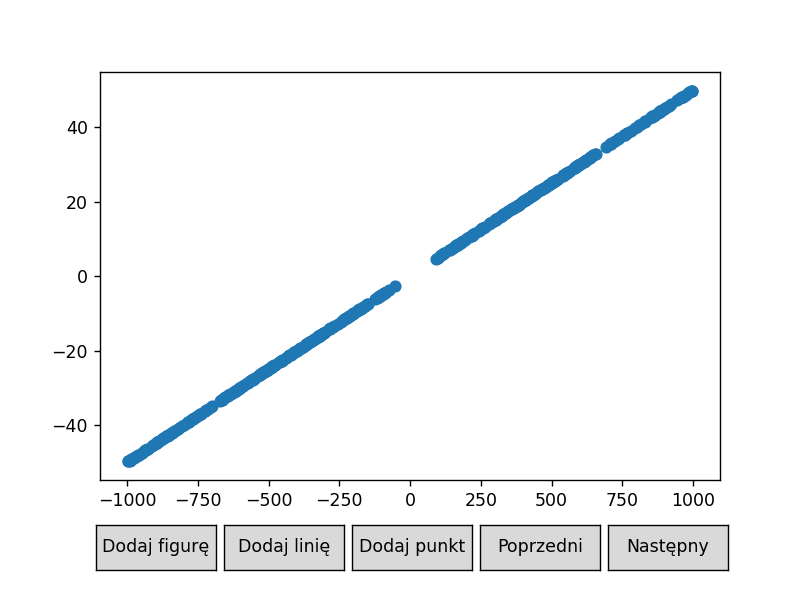

In [189]:
divide_by_3x3det(a,b,p4)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det(a,b,p4)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]: diff.append((set1[i][0],set1[i][1]))

%matplotlib notebook

plot = Plot(points=[PointsCollection(diff)])
plot.draw()

# Points differences, det 2x2 and numpy 2x2

<IPython.core.display.Javascript object>


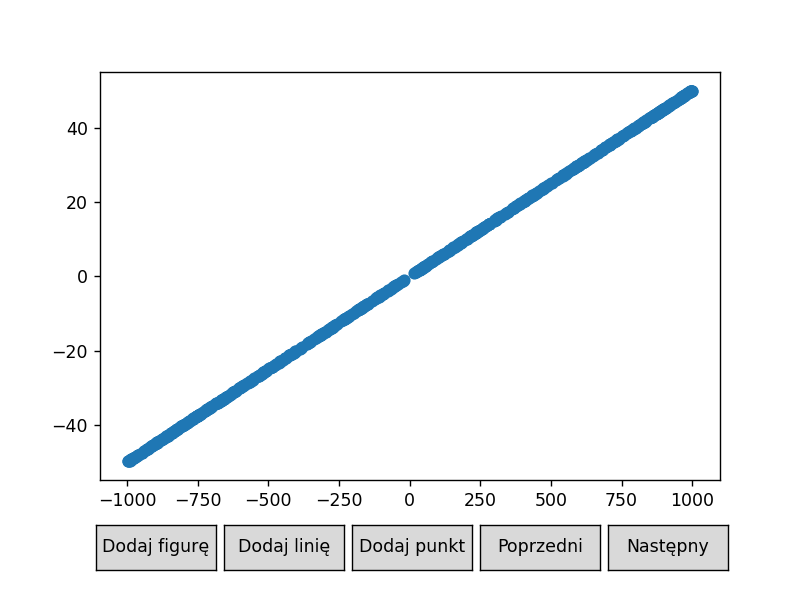

In [190]:
divide_by_2x2det(a,b,p4)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_py_det2x2(a,b,p4)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]: diff.append((set1[i][0],set1[i][1]))

%matplotlib notebook

plot = Plot(points=[PointsCollection(diff)])
plot.draw()

# Points differences 3x3 and 2x2

<IPython.core.display.Javascript object>


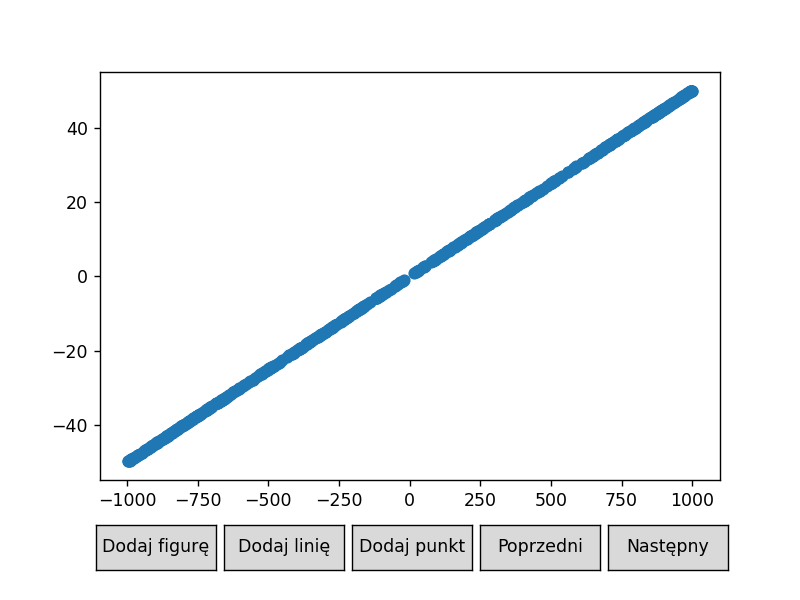

In [191]:
divide_by_3x3det(a,b,p4)
set1=[]
set1.extend(left)
set1.extend(straight)
set1.extend(right)
divide_by_2x2det(a,b,p4)
set2=[]
set2.extend(left)
set2.extend(straight)
set2.extend(right)
set1.sort()
set2.sort()
diff=[]
for i in range(len(set1)):
    if not set1[i][2]==set2[i][2]: diff.append((set1[i][0],set1[i][1]))

%matplotlib notebook

plot = Plot(points=[PointsCollection(diff)])
plot.draw()